In [12]:
%matplotlib widget

from dataclasses import dataclass
import math
import matplotlib.pyplot as plt
import numpy as np
import sympy as sy
from sympy.utilities.lambdify import lambdify

from typing import Callable


In [13]:
# functions from the in class notebooks
def func_inv(xvals: np.ndarray, cdf_vals: np.ndarray, u: np.ndarray) -> np.ndarray:
    """A function to compute the inverse cdf from a discrete set of values

    Args:

        xvals: (N, ) array of locations at which cdf_vals is obtained (sorted)
        cdf_vals: (N, ) array of values of the cdf (sorted)
        u: (M, )Locations at which to evaluate the inverse CDF. an array of numbers between 0 and 1.

    Returns:
        ret: (M, ) array of locations of the inverse CDF
    """

    assert np.all(u < 1) and np.all(u > 0)

    M = u.shape[0]
    ret = np.zeros((M))
    for jj in range(M):
        inds = (cdf_vals - u[jj] > 0).nonzero()
        ret[jj] = xvals[inds[0][0]]
    return ret


@dataclass
class MonteCarloEstimate:
    estimate: np.ndarray
    samples: np.ndarray
    evaluations: np.ndarray


def monte_carlo(num_samples: int,
                sample_generator: Callable[[int], np.ndarray],
                g_evaluator: Callable[[np.ndarray], np.ndarray],
                cumsum: bool = False):
    """Perform Monte Carlo sampling.

    Inputs
    ------
    num_samples: number of samples
    sample_generator: A function that generates samples with signature sample_generator(nsamples)
    g_evaluator: a function that takes as inputs the samples and outputs the evaluations.
                 The outputs can be any dimension, however the first dimension should have size *num_samples*
    cumsum: An option to return estimators of all sample sizes up to num_samples

    Returns
    -------
    A Monte Carlo estimator of the mean, samples, and evaluations
    """
    samples = sample_generator(num_samples)
    evaluations = g_evaluator(samples)
    if cumsum is False:
        estimate = np.sum(evaluations, axis=0) / float(num_samples)
    else:
        estimate = np.cumsum(evaluations, axis=0) / \
            np.arange(1, num_samples + 1, dtype=np.float64)

    return MonteCarloEstimate(estimate, samples, evaluations)

In [14]:
ALPHA = 3/2

# get the equations for the pareto distribution using sympy
# Note: these will generate warnings for x < 1 because sympy detects a
#       potential negative raised to a fractional power and division by zero,
#       but that's ok since we will never use the 2nd branch of the piecewise
#       function for x < 1
x = sy.Symbol('x')
# we dont need to normalize this because this already integrates to 1 as x->inf
pdf = sy.Piecewise((0, x < 1), (ALPHA / (x**(ALPHA+1)), True))
print(f"Pareto PDF: {pdf}")

# only integrating after 1 since the function is 0 before 1
cdf = sy.integrate(pdf, (x, 1, x))
print(f"Pareto CDF: {cdf}")

# the symbol Fx = the function cdf, so we can solve for x in this equation to get the inverse
Fx = sy.Symbol('Fx')
cdf_inv = sy.solve(sy.Eq(Fx,  cdf), x)[0]
print(f"Pareto CDF Inverse: {cdf_inv}")

func_pdf = lambdify(x, pdf)  # convert pdf into a numerical function
func_cdf = lambdify(x, cdf)  # convert cdf into a numerical function
func_cdf_inv = lambdify(Fx, cdf_inv)  # convert cdf into a numerical function

Pareto PDF: Piecewise((0, x < 1), (1.5/x**2.5, True))
Pareto CDF: Piecewise((0, x < 1), (1.0 - 1.0/x**1.5, True))
Pareto CDF Inverse: Piecewise(((-1/(Fx - 1.0))**(2/3), (-1/(Fx - 1.0))**(2/3) >= 1.0), (nan, True))


<lambdifygenerated-7>:2: RuntimeWarning: invalid value encountered in power
  return select([less(x, 1),True], [0,1.5*x**(-2.5)], default=nan)
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in power
  return select([less(x, 1),True], [0,1.0 - 1.0*x**(-1.5)], default=nan)


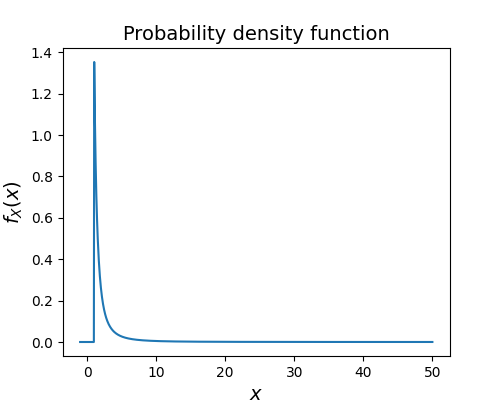

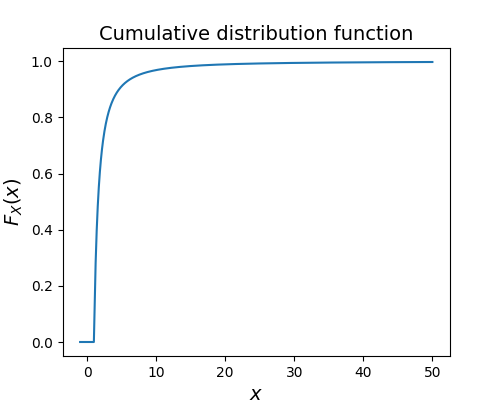

In [15]:

# x for plotting the pdf and cdf
x = np.linspace(-1, 50, 1000)

plt.figure(figsize=(5, 4))
pdf = func_pdf(x)
plt.plot(x, pdf)
plt.xlabel(r'$x$', fontsize=14)
plt.ylabel(r'$f_X(x)$', fontsize=14)
plt.title('Probability density function', fontsize=14)
plt.savefig('f1.svg')
# plt.show()

plt.figure(figsize=(5, 4))
cdf = func_cdf(x)
plt.plot(x, cdf)
plt.xlabel(r'$x$', fontsize=14)
plt.ylabel(r'$F_X(x)$', fontsize=14)
plt.title('Cumulative distribution function', fontsize=14)
plt.savefig('f2.svg')
# plt.show()

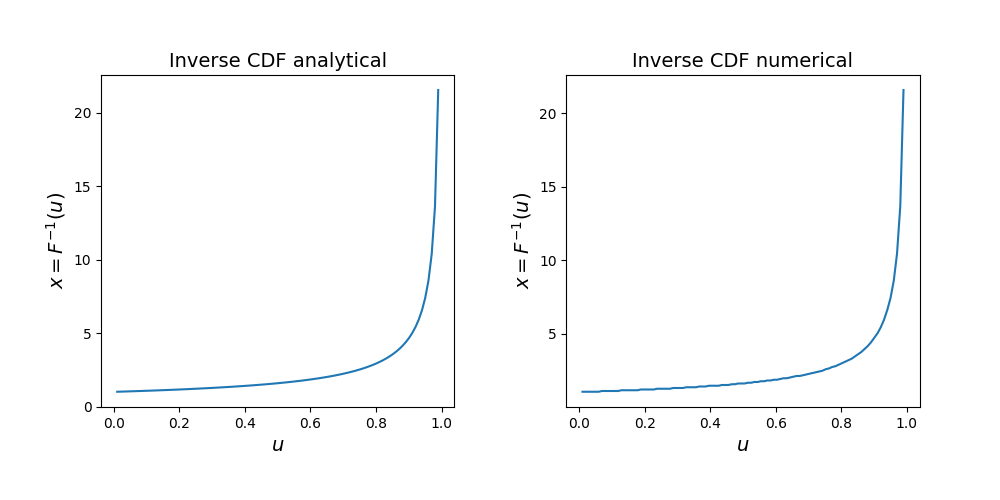

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=5)
# uniform samples in [0, 1] to plot inverse CDF
us = np.linspace(0.01, 0.99, 100)

xs = func_cdf_inv(us)
ax[0].plot(us, xs)
ax[0].set_xlabel(r'$u$', fontsize=14)
ax[0].set_ylabel(r'$x = F^{-1}(u)$', fontsize=14)
ax[0].set_title('Inverse CDF analytical', fontsize=14)

# using the CDF for x samples, find the nearest x for uniform samples on CDF to check the inverse CDF
xs_check = func_inv(x, cdf, us)
ax[1].plot(us, xs_check)
ax[1].set_xlabel(r'$u$', fontsize=14)
ax[1].set_ylabel(r'$x = F^{-1}(u)$', fontsize=14)
ax[1].set_title('Inverse CDF numerical', fontsize=14)

# fig.show()
fig.savefig('f3.svg')

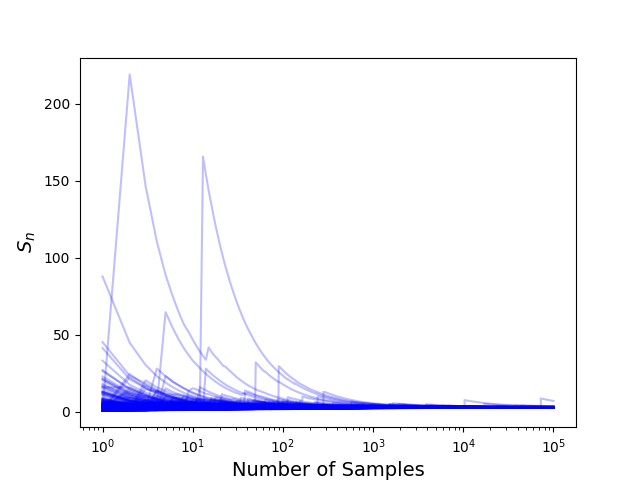

In [17]:

# run monte carlo simulations

# fix seed for reproducibility
np.random.seed(42)
# run independent sequences and plot them
nsequences = 500
nsamples = 100001
estimate_vals = np.zeros((nsequences, nsamples))
plt.figure()
for ii in range(nsequences):
    mc = monte_carlo(nsamples, np.random.rand, func_cdf_inv, cumsum=True)
    estimate_vals[ii, :] = mc.estimate
    plt.semilogx(np.arange(1, nsamples+1),
                 estimate_vals[ii, :], '-', color='blue', alpha=0.25)
# plt.axhline(y=int_numeric, color='red', linewidth=5)
plt.xlabel('Number of Samples', fontsize=14)
plt.ylabel(r'$S_n$', fontsize=14)
plt.savefig('f4.svg')
# plt.show()

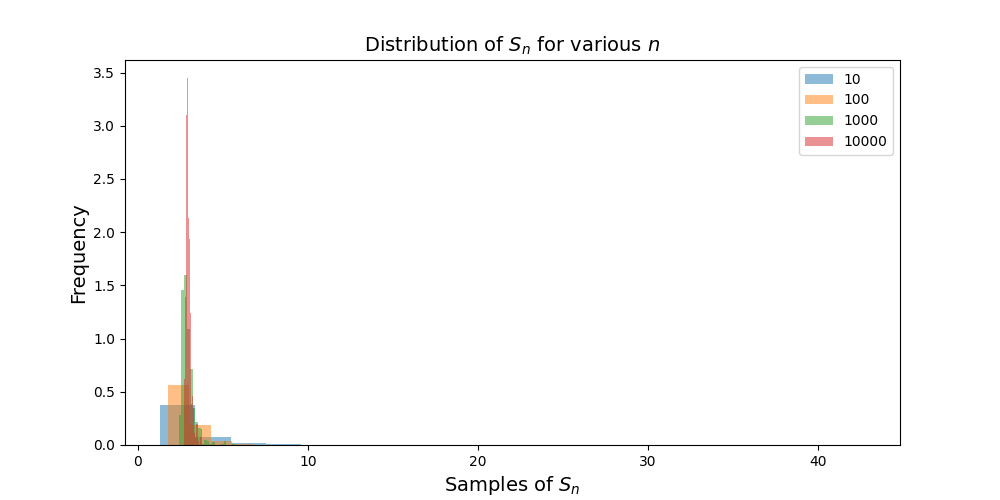

In [18]:
# look at the sampling distribution at various n
# number of samples, stick to 4 for visualization
n_range = [10, 100, 1000, 10000]


plt.figure(figsize=(10, 5))
for n in n_range:
    plt.hist(estimate_vals[:, n], bins=20,
             alpha=0.5, density=True, label=f"{n}")
plt.xlabel(r'Samples of $S_n$', fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title(r'Distribution of $S_n$ for various $n$', fontsize=14)
plt.legend()
plt.savefig('f5.svg')

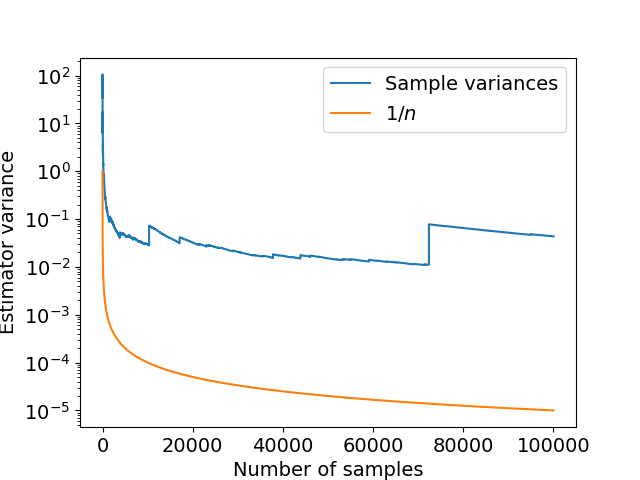

In [19]:
# look at convergence rate by examining the variance of the estimator

plt.figure()
# variance of the histogram at each $n$
variances = np.var(estimate_vals, axis=0)
plt.semilogy(
    np.arange(1, variances.shape[0]+1), variances, label='Sample variances')
plt.semilogy(np.arange(
    1, variances.shape[0]+1), 1/(np.arange(1, variances.shape[0]+1)), label=r'$1/n$')
plt.ylabel('Estimator variance', fontsize=14)
plt.xlabel('Number of samples', fontsize=14)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.show()
plt.savefig('f6.svg')